# Rauschen

## initial imports

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks,find_peaks_cwt
import scipy.signal as sig
import scipy.special as sp
import scienceplots
plt.figure()
plt.style.use('science')
plt.rcParams['errorbar.capsize'] = 5
plt.rcParams['text.usetex'] = False # disable latex
plt.rcParams['figure.dpi'] = 150
import os
import fp

<Figure size 640x480 with 0 Axes>

In [2]:
#aliases
from uncertainties import ufloat as uf
from uncertainties.unumpy import uarray as ua
from uncertainties.unumpy import nominal_values as nv
from uncertainties.unumpy import std_devs as sd

In [3]:
outdir = f'plots/rauschen/'
datadir = f'data/rauschen/'
os.makedirs(outdir, exist_ok=True)

## Part 1 Johnson - Nyquist Noise

In [4]:
dat1 = pd.read_csv(datadir+'Rauschen - 1 - Johnson R,df.tsv',delimiter='\t',decimal=',')
dat1

,Messung,g2,f1 Hz,f2 Hz,df kHz,R Ohm,V mV,uV,comment
0,1,5000,300,330,105,1,8.3,0.3,hintergrund 1
1,2,5000,100,1000,1000,1,59.0,1.5,hintergrund 2
2,3,5000,30,3300,3632,1,205.0,1.5,hintergrund 3
3,4,5000,30,10000,11075,1,602.0,3.0,hintergrund 4
4,5,500,10,100000,111061,1,63.2,0.1,hintergrund 5
5,6,5000,300,330,105,100,8.5,0.2,widerstand 1.1
6,10,5000,100,1000,1000,100,60.0,1.0,widerstand 1.2
7,14,5000,30,3300,3632,100,211.0,1.0,widerstand 1.3
8,18,1000,30,10000,11075,100,26.6,0.1,widerstand 1.4
9,22,1000,10,100000,111061,100,255.0,0.3,widerstand 1.5


In [5]:
def nyquist(R,T,df):
    return 4*con.k*T*R*df
def kb(R,T,df,v2):
    return v2/(4*R*T*df)
def dv2n(v, g1, g2, ):
    return v*1e-3 * 10 / (g1*g2)


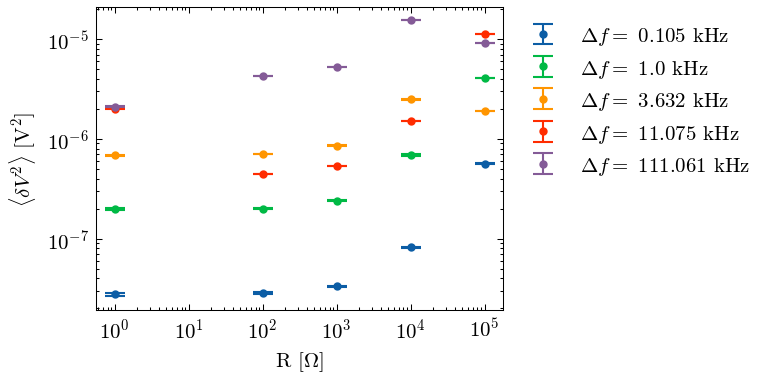

In [6]:
# over R
plt.figure()
for i in range(5):
    dat = dat1[i::5]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    df = dat['df kHz'].mean()*1e-3
    plt.errorbar(dat['R Ohm'],nv(y),yerr=sd(y),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [$\Omega$]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')

plt.savefig(outdir+'1-johnson_rauschen_R.pdf',bbox_inches='tight')

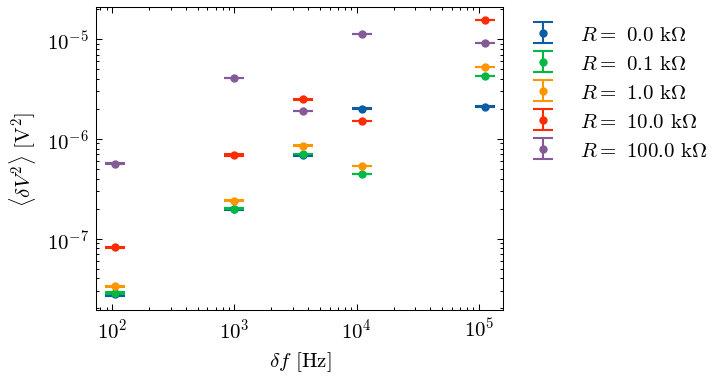

In [7]:
# over df unbereinigt
plt.figure()
# dat = dat1[0:5]
# y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(0,5):
    dat = dat1[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'1-johnson_rauschen_df_raw.pdf',bbox_inches='tight')

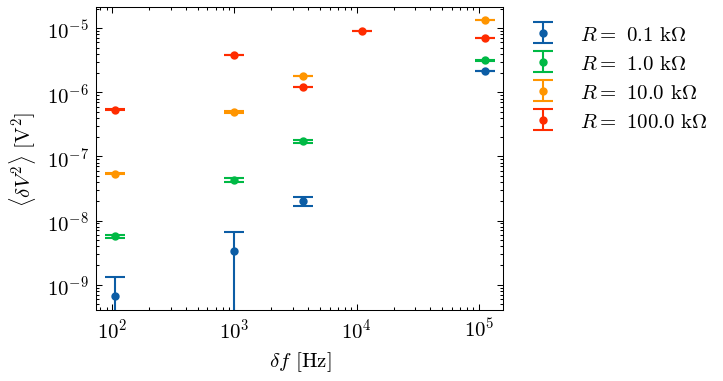

In [8]:
# over df
plt.figure()
dat = dat1[0:5]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(1,5):
    dat = dat1[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'1-johnson_rauschen_df.pdf',bbox_inches='tight')

## 2 Shot Noise

In [9]:
dat2 = pd.read_csv(datadir+'Rauschen - 2 - Shot.tsv',delimiter='\t',decimal=',')
dat2

,Messung,g2,f1 Hz,f2 Hz,df Hz,R kOhm,Vdc V,uVdc,Vn mV,uVn,comment
0,21,2000,1000,10000,9997,10,0.00029,0.0005,11.35,0.05,hintergrund 1
1,1,2000,1000,10000,9997,10,-0.42420,0.0002,68.50,0.20,NaN
2,2,2000,1000,10000,9997,10,-0.85220,0.0002,126.00,0.50,NaN
3,3,2000,1000,10000,9997,10,-1.31000,0.0002,187.00,2.00,NaN
4,4,2000,1000,10000,9997,10,-1.83400,0.0002,265.00,5.00,NaN
5,5,2000,1000,10000,9997,10,-2.23000,0.0005,315.00,4.00,NaN
6,6,2000,1000,10000,9997,10,-2.67000,0.0005,371.00,2.00,NaN
7,7,2000,1000,10000,9997,10,-3.12000,0.0005,437.00,4.00,NaN
8,8,2000,1000,10000,9997,10,-3.56000,0.0005,498.00,4.00,NaN
9,9,2000,1000,10000,9997,10,-4.01000,0.0005,555.00,8.00,NaN


In [10]:
def shot(i_dc,df):
    return 2*con.e*i_dc*df
def e_0 (i_dc,df, di2):
    return di2/(2*i_dc*df)
def i_dc(v_dc,rf):
    return -v_dc/rf
def di2s(v, g1, g2, rf):
    return v*1e-3 * 10 / (g1*g2*rf)

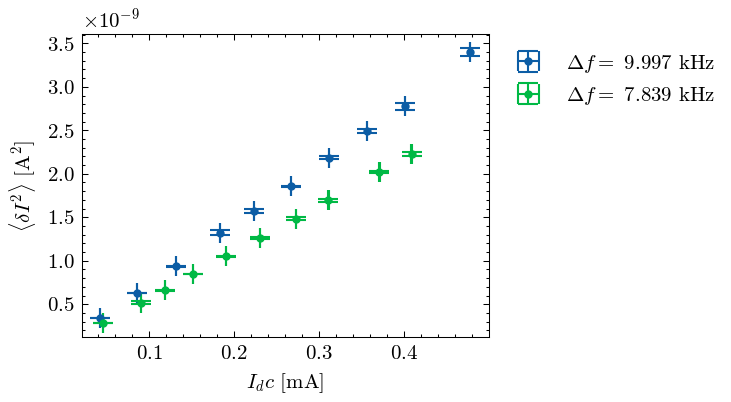

In [11]:
# over df Raumtemp raw
plt.figure()

for i in range(0,2):
    dat = dat2[11*i+1:11*(i+1)]
    v_dc = ua(dat['Vdc V'],dat[f'uVdc'])
    v_n = ua(dat['Vn mV'],dat[f'uVn'])
    r = dat['R kOhm'].mean()
    x = i_dc(v_dc, r*1e3)*1e3
    y = di2s(v_n, 100, dat['g2'], r*1e3)
    df = dat['df Hz'].mean()*1e-3
    plt.errorbar(nv(x),nv(y),yerr=sd(y),xerr=sd(x),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$I_dc$ [mA]')
plt.ylabel(r'$\langle\delta I^2\rangle$ [A$^2$]')
plt.savefig(outdir+'2-schrot_rauschen_raw.pdf',bbox_inches='tight')

## 3 Absolute Zero

In [12]:
dat3 = pd.read_csv(datadir+'Rauschen - 3 - Johnson T.tsv',delimiter='\t',decimal=',')
dat3[::5]

,Messung,g2,f1 Hz,f2 Hz,df kHz,R Ohm,uR,T Celsius,dT,V mV,uV,comment
0,1,5000,300,330,105,11.0,1.2,21,1,7.7,0.1,R_A (Hintergrund)
5,2,5000,300,330,105,9970.0,40.0,21,1,23.8,0.1,R_B
10,3,5000,300,330,105,100500.0,1000.0,21,1,168.0,2.0,R_C
15,16,500,300,330,105,11.8,2.0,-195,1,21.0,0.5,R_A (Hintergrund)
20,17,500,300,330,105,9960.0,10.0,-195,1,35.1,0.1,R_B
25,18,500,300,330,105,101000.0,1000.0,-195,1,93.2,0.2,R_C


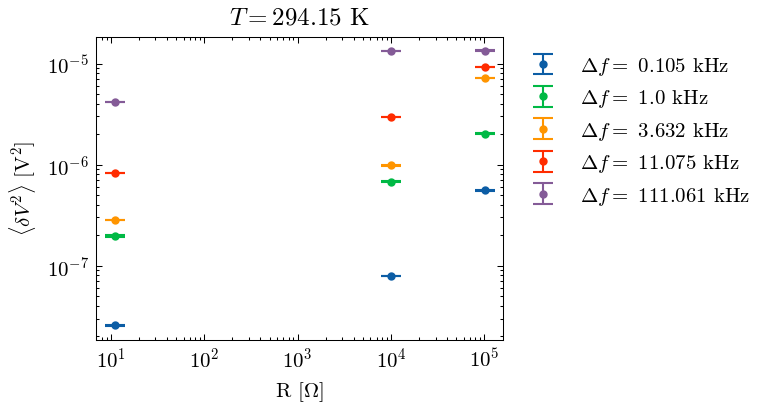

In [13]:
# over R raumtemperatur
plt.figure()
plt.title(f'$T ={round(dat3["T Celsius"][0]+273.15,2)}$ K')

for i in range(5):
    dat = dat3[i:15:5]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    df = dat['df kHz'].mean()*1e-3
    plt.errorbar(dat['R Ohm'],nv(y),yerr=sd(y),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [$\Omega$]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df-raumtemperatur.pdf',bbox_inches='tight')


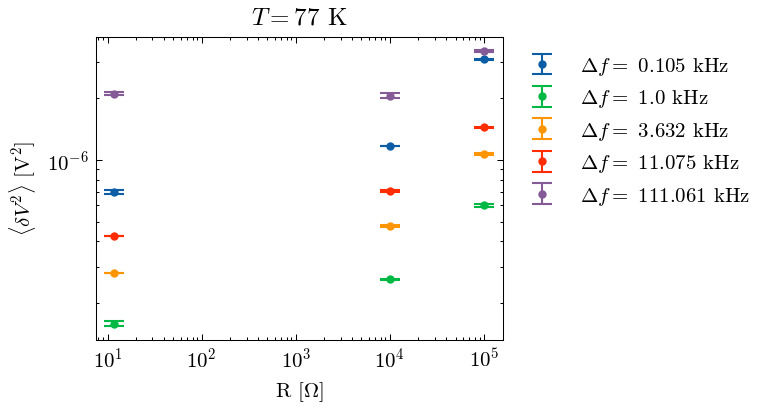

In [14]:
# over R flussigstickstoff
plt.figure()
plt.title(f'$T =77$ K')

for i in range(5):
    dat = dat3[i+15::5]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    df = dat['df kHz'].mean()*1e-3
    plt.errorbar(dat['R Ohm'],nv(y),yerr=sd(y),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [$\Omega$]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_R-77K.pdf',bbox_inches='tight')


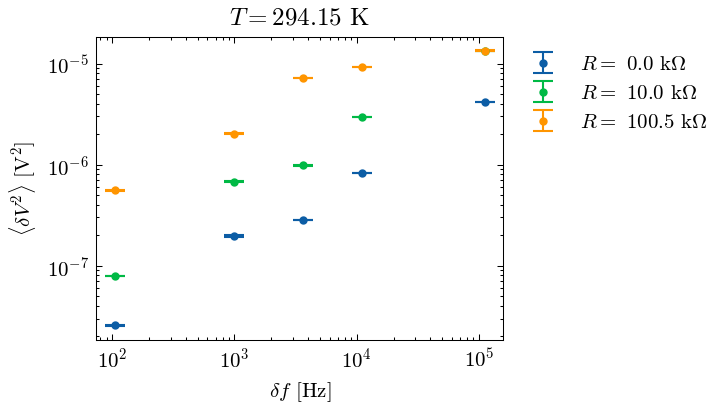

In [15]:
# over df Raumtemp raw
plt.figure()
plt.title(f'$T ={round(dat3["T Celsius"][0]+273.15,2)}$ K')

dat = dat3[0:5]
# y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(0,3):
    dat = dat3[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df_raw-raumtemperatur.pdf',bbox_inches='tight')

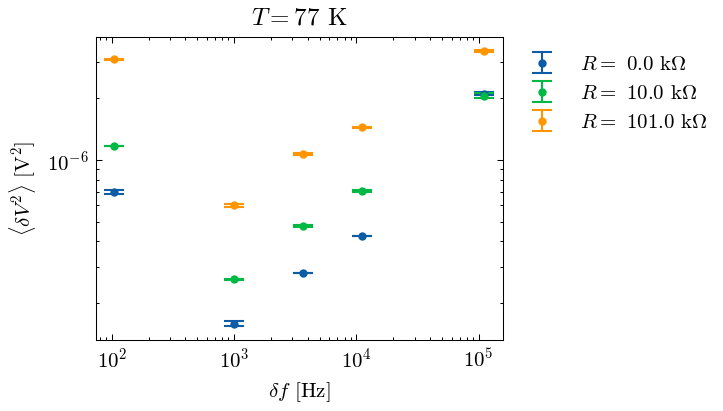

In [16]:
# over df Fluessigstickstoff
plt.figure()
plt.title(f'$T =77$ K')
dat = dat3[15:20]
# y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(0,3):
    dat = dat3[15+5*i:15+5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df_raw-77K.pdf',bbox_inches='tight')

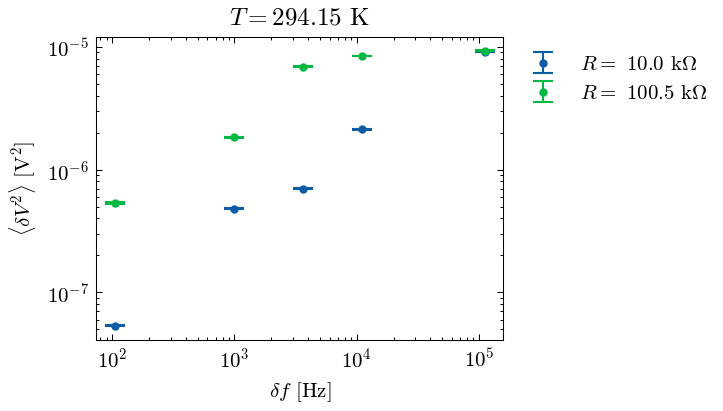

In [17]:
# over df Raumtemp
plt.figure()
plt.title(f'$T ={round(dat3["T Celsius"][0]+273.15,2)}$ K')

dat = dat3[0:5]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(1,3):
    dat = dat3[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df-raumtemperatur.pdf',bbox_inches='tight')

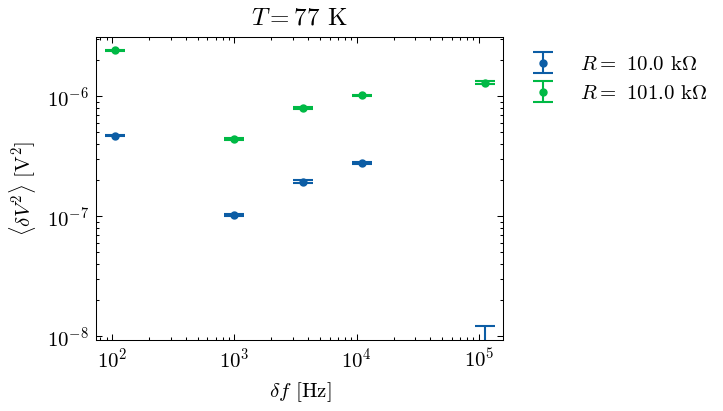

In [18]:
# over df Fluessigstickstoff
plt.figure()
plt.title(f'$T =77$ K')
dat = dat3[15:20]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(1,3):
    dat = dat3[15+5*i:15+5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df-77K.pdf',bbox_inches='tight')